In [1]:
import matplotlib.pyplot as plt
import csv
from  scipy.interpolate  import  interp1d
from scipy import optimize

# Evaluation on Thermal Resistance of Flat Glasses and Thermal Transmittance of Glazing based on JIS R 3107 / JIS R 3107 に基づく板ガラス類の熱抵抗及び建築における熱貫流率の算定方法

## 1. Introduction

## 2. Type

## 3. Functions

### 3.1 Thermal Transmittance (U value) / 熱貫流率

$ \displaystyle \frac{1}{U} = \frac{1}{h_e} + R + \frac{1}{h_i} $

$ U $ is the thermal transmittance / 熱貫流率 (W/m<sup>2</sup>K);  
$ h_e $ is the external thermal transfer coefficient / 室外側表面熱伝達率 (W/m<sup>2</sup>K);  
$ h_i $ is the internal thermal transfer coefficient / 室内側表面熱伝達率 (W/m<sup>2</sup>K);  
$ R $ is the thermal resistance of the flat glasses / 板ガラス類の熱抵抗 (m<sup>2</sup>K/W);  

In [2]:
def get_U( he, hi, R ):
    return 1 / ( 1/he +  R + 1/hi )

$ \displaystyle R_g = \frac{d_m}{\Lambda_m} $

$ R_g $ is the thermal resistance of the glasses / ガラスの熱抵抗 (m<sup>2</sup>K/W);  
$ d_m $ is the mean thickness of the composed flat glasses or the film of the laminated glasses/ 構成するガラス板又は合わせガラスの中間膜の平均的な厚さ (m);  
$ \Lambda_m $ is the mean thermal conductivity of the composed flat glasses or the film of the laminated glasses/ 構成するガラス板又は合わせガラスの中間膜の平均的な熱伝導率 (W/mK).  

$ \Lambda_m = 1 $

In [3]:
def get_Rg( dm ):
    lambdam = 1.0
    return dm / lambdam

Single glass:

$ \displaystyle R = \sum^M R_{g,j} $

More than double glasses:

$ \displaystyle R = \sum^N \frac{1}{h_{s,i}} + \sum^M R_{g,j} $

$ R $ is the thermal resistance of the flat glasses / 板ガラス類の熱抵抗 (m<sup>2</sup>K/W);  
$ h_s $ is the thermal conductance of air layer between the glasses / 中空層の熱コンダクタンス (W/m<sup>2</sup>K).

In [4]:
def get_R( hs, Rg ):
    if len(hs) == 0:
        return sum( Rg )
    else:
        return sum( [ 1/hsi for hsi in hs ] ) + sum( Rg )

$ \displaystyle h_s = h_r + h_g $

$ h_s $ is the thermal conductance of air layer between the glasses / 中空層の熱コンダクタンス (W/m<sup>2</sup>K);  
$ h_r $ is the radiative thermal conductance / 放射熱コンダクタンス (W/m<sup>2</sup>K);  
$ h_g $ is the thermal conductance caused by conduction and convection of the air (the air thermal conductance) / 気体の伝導と対流による熱コンダクタンス(気体コンダクタンス) (W/m<sup>2</sup>K);  

In [5]:
def get_hs( hr, hg ):
    return hr + hg

### 3.2 Radiative Thermal Conductance / 放射熱コンダクタンス

$ \displaystyle h_r = 4 \times \sigma \times \left( \frac{1}{\epsilon_1} + \frac{1}{\epsilon_2} -1 \right)^{-1} \times T_m^3 $

$ h_r $ is the radiative thermal conductance / 放射熱コンダクタンス (W/m<sup>2</sup>K);  
$ \sigma $ is Stefan-Boltzmann constant / ステファン・ボルツマン定数 (W/m<sup>2</sup>K<sup>4</sup>);  
$ \epsilon_1 $, $ \epsilon_2 $ are the corrected emissivity of two glass surfaces surfaced to the air layer / 中空層に接する2つのガラス面の修正放射率;  
$ T_m $ is the average value of the absolute temperatures at the two glass surfaces surfaced to the air layer / 中空層に接する2つのガラス面の絶対温度の値の平均値 (K).

$ \displaystyle \sigma = 5.67 \times 10 ^ {-8}$

In [6]:
def get_hr( e1, e2, Tm ):
    sigma = 5.67 * 10 ** (-8)
    return 4 * sigma / ( 1/e1 + 1/e2 - 1 ) * ( Tm ** 3 )

### 3.3 Air Thermal Conductance / 気体熱コンダクタンス

$ \displaystyle h_g = C \times \frac{\lambda}{s} $

$ h_g $ is the thermal conductance caused by conduction and convection of the air (the air thermal conductance) / 気体の伝導と対流による熱コンダクタンス(気体コンダクタンス) (W/m<sup>2</sup>K);  
$ C $ is the convection effect coefficient / 対流効果係数;  
$ \lambda $ is the thermal conductivity of the air / 気体の熱伝導率 (W/mK);  
$ s $ is the thickness of the air layer / 中空層の厚さ (m).

$ Nu \le 1 $ のとき、$ C = 1 $  
$ Nu \gt 1 $ のとき、$ C = Nu $

$Nu$ is Nusselt number.

In [7]:
def get_hg( l, s, Nu ):
    C = 1 if Nu <= 1 else Nu
    return C * l / s

$ \displaystyle Nu = A \times \left( Gr \times Pr \right)^n $ 

$ A $ and $ n $ are defined corresponding to the tilt angle of the air layer and the direction of heat flow / 中空層の傾斜角と熱流方向によって決まる数値;  
$ Gr $ is Grashof number;  
$ Pr $ is Prandtl number.

| | $A$ | $n$ | symbol |
| --- | --- | --- | --- |
| Air layer is vertical and heat flow orientation is horizontal | 0.035 | 0.38 | 'horizontal' |
| Air layer is horizontal and heat flow orientation is upstream | 0.16 | 0.28 | 'up' |
| Air layer is 45 degree and heat flow orientation is upstream | 0.10 | 0.31 | 'up45' |
| heat flow orientation is downstream | 1 | 0 | 'down' |

In [8]:
def get_Nu( Gr, Pr, heatFlowOrientation ):
    return {
        'horizontal' : 0.035 * ( Gr * Pr )**0.38,
        'up'         : 0.16  * ( Gr * Pr )**0.28,
        'up45'       : 0.10  * ( Gr * Pr )**0.31,
        'down'       : 1     * ( Gr * Pr )**0
    }[heatFlowOrientation]

$ \displaystyle Gr = \frac{ 9.81 \times s^3 \times \Delta T \times \rho ^2 }{ T'_m \times \mu ^2 } $

$ Gr $ is Grashof number;  
$ s $ is the thickness of the air layer / 中空層の厚さ (m);  
$ \Delta T $ is the temperature difference of the two surface surfaced the air layer / 中空層に接する2面間の温度差 (K);  
$ \rho $ is the density of the air / 気体の密度 (kg/m<sup>3</sup>);  
$ T'_m $ is the average temperature of the air at the air layer / 中空層の気体の平均温度 (K);  
$ \mu $ is the viscosity of the air / 気体の粘度 (N・s/m<sup>2</sup>= kg/ms).

In [9]:
def get_Gr( s, dT, rho, Tmd, mu ):
    return 9.81 * ( s**3 ) * dT * ( rho**2 ) / Tmd / (mu**2)

$ \displaystyle Pr = \frac{ \mu \times c }{ \lambda } $

$ Pr $ is Prandtl number;  
$ \mu $ is the viscosity of the air / 気体の粘度 (N・s/m<sup>2</sup>= kg/ms);  
$ c $ is the specific heat of the air / 気体の比熱 (J/kgK);  
$ \lambda $ is the thermal conductivity of the air / 気体の熱伝導率 (W/mK).

In [10]:
def get_Pr( mu, c, l ):
    return mu * c / l

### 3.4 Corrected Emissivity

| nomarl emissivity $ \epsilon_n $ | coefficient $ \frac{\epsilon}{\epsilon_n} $ |
| --- | --- |
| 0.03 | 1.22 |
| 0.05 | 1.18 |
| 0.1 | 1.14 |
| 0.2 | 1.10 |
| 0.3 | 1.06 |
| 0.4 | 1.03 |
| 0.5 | 1.00 |
| 0.6 | 0.98 |
| 0.7 | 0.96 |
| 0.8 | 0.95 |
| 0.89 | 0.94 |

$ \epsilon_n $ is normal emissivity / 垂直放射率  
$ \epsilon $ is corrected emissivity / 修正放射率

In [11]:
def getCorrectedCoefficient( e ):
    # e : normal emissivity
    x = [ 0.03, 0.05, 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.89 ]
    y = [ 1.22, 1.18, 1.14, 1.10, 1.06, 1.03, 1.00, 0.98, 0.96, 0.95, 0.94 ]
    return float(interp1d(x,y)(e))

#### Example

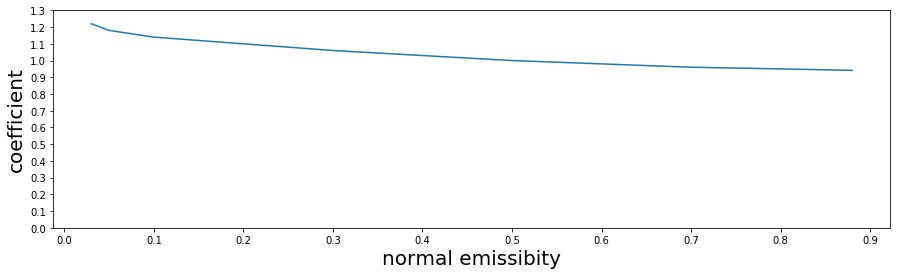

In [12]:
fig = plt.figure(figsize=(15,4))
xs = [ n * 0.01 for n in range(3, 89) ]
ys = [ getCorrectedCoefficient( e = x ) for x in xs ]
ax = fig.add_subplot(1,1,1)
ax.plot(xs,ys)
ax.set_xticks([ n * 0.1 for n in range(0, 10) ])
ax.set_yticks([ n * 0.1 for n in range(0, 14) ])
ax.set_xlabel('normal emissibity', fontsize = 20 )
ax.set_ylabel('coefficient', fontsize = 20 )
plt.show()

In case of not low E glass, the corrected emissivity is 0.837.

In [13]:
def getCorrectedEmissivity( isLowE, e ):
    # e : normal emissivity
    if isLowE:
        return e * getCorrectedCoefficient( e )
    else:
        return 0.837    

#### Example

Low E with 0.11 of $ \epsilon_n$ 

In [14]:
getCorrectedEmissivity( isLowE = True, e = 0.11 )

0.12495999999999999

Not Low E

In [15]:
getCorrectedEmissivity( isLowE = False, e = 0.11 )

0.837

### 3.5 Air Property

#### air

| temperature $\theta$ <br> degree C | density $\rho$ <br> kg/m<sup>3</sup> | viscosity $\mu$ <br> 10<sup>-5</sup> kg/ms | thermal conductivity $\lambda$ <br> 10<sup>-2</sup> W/mK | specific heat $c$ <br> 10<sup>3</sup> J/kgK |
| --- | --- | --- | --- | --- |
| -10 | 1.326 | 1.661 | 2.336 | 1.008 |
|   0 | 1.277 | 1.711 | 2.416 | 1.008 |
|  10 | 1.232 | 1.761 | 2.496 | 1.008 |
|  20 | 1.189 | 1.811 | 2.576 | 1.008 |

#### argon

| temperature $\theta$ <br> degree C | density $\rho$ <br> kg/m<sup>3</sup> | viscosity $\mu$ <br> 10<sup>-5</sup> kg/ms | thermal conductivity $\lambda$ <br> 10<sup>-2</sup> W/mK | specific heat $c$ <br> 10<sup>3</sup> J/kgK |
| --- | --- | --- | --- | --- |
| -10 | 1.829 | 2.038 | 1.584 | 0.519 |
|   0 | 1.762 | 2.101 | 1.634 | 0.519 |
|  10 | 1.699 | 2.164 | 1.684 | 0.519 |
|  20 | 1.640 | 2.228 | 1.734 | 0.519 |

#### SF<sub>6</sub>

| temperature $\theta$ <br> degree C | density $\rho$ <br> kg/m<sup>3</sup> | viscosity $\mu$ <br> 10<sup>-5</sup> kg/ms | thermal conductivity $\lambda$ <br> 10<sup>-2</sup> W/mK | specific heat $c$ <br> 10<sup>3</sup> J/kgK |
| --- | --- | --- | --- | --- |
| -10 | 6.844 | 1.383 | 1.119 | 0.614 |
|   0 | 6.602 | 1.421 | 1.197 | 0.614 |
|  10 | 6.360 | 1.459 | 1.275 | 0.614 |
|  20 | 6.118 | 1.497 | 1.354 | 0.614 |

#### krypton

| temperature $\theta$ <br> degree C | density $\rho$ <br> kg/m<sup>3</sup> | viscosity $\mu$ <br> 10<sup>-5</sup> kg/ms | thermal conductivity $\lambda$ <br> 10<sup>-2</sup> W/mK | specific heat $c$ <br> 10<sup>3</sup> J/kgK |
| --- | --- | --- | --- | --- |
| -10 | 3.832 | 2.260 | 0.842 | 0.245 |
|   0 | 3.690 | 2.330 | 0.870 | 0.245 |
|  10 | 3.560 | 2.400 | 0.900 | 0.245 |
|  20 | 3.430 | 2.470 | 0.926 | 0.245 |

In [16]:
class AirProperty:

    def __init__( self, density, viscosity, thermalConductivity, specificHeat):
        self.density             = density
        self.viscosity           = viscosity
        self.thermalConductivity = thermalConductivity
        self.specificHeat        = specificHeat
    
    def SetProp( airtype, temp ):
        T   = [ -10+273.15, 0+273.15, 10+273.15, 20+273.15]
        rho = {
            'air':     [ 1.326, 1.277, 1.232, 1.189 ],
            'argon':   [ 1.829, 1.762, 1.699, 1.640 ],
            'SF6':     [ 6.844, 6.602, 6.360, 6.118 ],
            'krypton': [ 3.832, 3.690, 3.560, 3.430 ]
        }[airtype]
        mu = {
            'air':     [ 0.00001661, 0.00001711, 0.00001761, 0.00001811 ],
            'argon':   [ 0.00002038, 0.00002101, 0.00002164, 0.00002228 ],
            'SF6':     [ 0.00001383, 0.00001421, 0.00001459, 0.00001497 ],
            'krypton': [ 0.00002260, 0.00002330, 0.00002400, 0.00002470 ]
        }[airtype]
        l = {
            'air':     [ 0.02336, 0.02416, 0.02496, 0.02576],
            'argon':   [ 0.01584, 0.01634, 0.01684, 0.01734],
            'SF6':     [ 0.01119, 0.01197, 0.01275, 0.01354],
            'krypton': [ 0.00842, 0.00870, 0.00900, 0.00926]
        }[airtype]
        c = {
            'air':     1008,
            'argon':    519,
            'SF6':      614,
            'krypton':  245
        }[airtype]
        
        return AirProperty( density             = float(interp1d(T,rho)(temp)),
                            viscosity           = float(interp1d(T,mu)(temp)),
                            thermalConductivity = float(interp1d(T,l)(temp)),
                            specificHeat        = c)

#### Example

In [17]:
p = AirProperty.SetProp( airtype = 'air', temp = 273.15 )
p.density, p.specificHeat, p.thermalConductivity, p.viscosity

(1.277, 1008, 0.02416, 1.711e-05)

#### Example

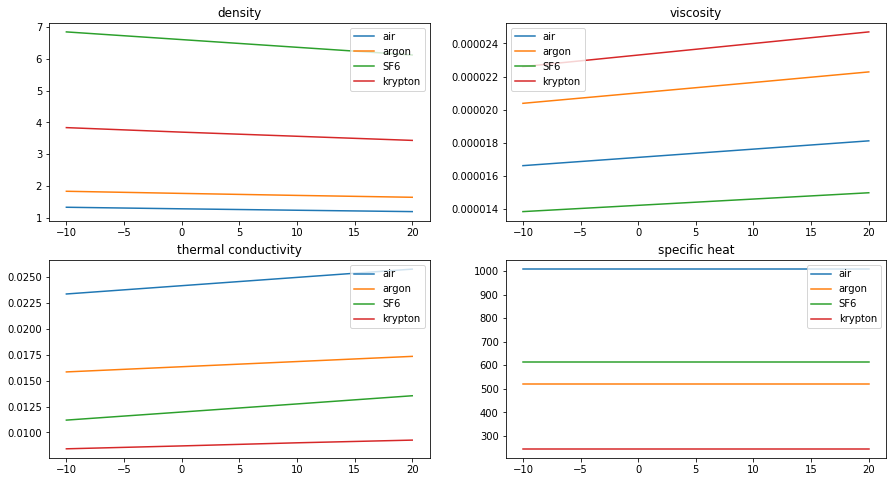

In [18]:
fig = plt.figure(figsize=(15,8))
xs = [ float(n - 10) for n in range(0, 31) ]
for i, air_property in enumerate(['density','viscosity','thermal conductivity','specific heat']):
    ax = fig.add_subplot(2,2,i+1)
    for airtype in [ 'air', 'argon', 'SF6', 'krypton' ]:
        ys = [ { 'density'              : AirProperty.SetProp( airtype = airtype, temp = x+273.15 ).density,
                 'viscosity'            : AirProperty.SetProp( airtype = airtype, temp = x+273.15 ).viscosity,
                 'thermal conductivity' : AirProperty.SetProp( airtype = airtype, temp = x+273.15 ).thermalConductivity,
                 'specific heat'        : AirProperty.SetProp( airtype = airtype, temp = x+273.15 ).specificHeat
               }[air_property] for x in xs ]
        ax.plot(xs,ys,label = airtype )
    ax.set_title(air_property)
    ax.legend()
plt.show()

#### Mixed Air

In [19]:
class AirComp:
    
    def __init__( self, aType, aVolumeRate ):
        self.aType       = aType
        self.aVolumeRate = aVolumeRate
        
    def getAirProperty( self, temp ):
        return AirProperty.SetProp( self.aType, temp )

In [20]:
def getMixedAirProperty( aComps, temp ):
    density             = sum( [ c.getAirProperty( temp ).density             * c.aVolumeRate for c in aComps ] )
    viscosity           = sum( [ c.getAirProperty( temp ).viscosity           * c.aVolumeRate for c in aComps ] )
    thermalConductivity = sum( [ c.getAirProperty( temp ).thermalConductivity * c.aVolumeRate for c in aComps ] )
    specificHeat        = sum( [ c.getAirProperty( temp ).specificHeat        * c.aVolumeRate for c in aComps ] )
    return AirProperty( density = density, viscosity = viscosity, thermalConductivity = thermalConductivity, specificHeat = specificHeat )

#### Example

In [21]:
p = getMixedAirProperty( [ AirComp( aType = 'air', aVolumeRate = 0.5 ), AirComp( aType = 'argon', aVolumeRate = 0.5 ) ], 20.0 + 273.15 )
p.density, p.viscosity, p.thermalConductivity, p.specificHeat

(1.4144999999999999, 2.0195e-05, 0.02155, 763.5)

### 3.6 Thermal Transfer Coefficient / 表面熱伝達率

#### External / 室外側

$ h_e = 4.9 \times \epsilon_e + 16.3 $

$ h_e $ is the external thermal transfer coefficient / 室外側表面熱伝達率 (W/m<sup>2</sup>K);  
$ \epsilon_e $ is the hemispherical emissivity at the external surface / ガラス表面の半球放射率.  
The hemispherical emissivity $ \epsilon_e $ is considered to be equals to the corrected emissivity.

In [22]:
def get_he( ee ):
    return 4.9 * ee + 16.3

#### Internal / 室内側

$ h_i = 5.4 \times \epsilon_i + 4.1 $

$ h_i $ is the internal thermal transfer coefficient / 室内側表面熱伝達率 (W/m<sup>2</sup>K);  
$ \epsilon_i $ is the hemispherical emissivity at the external surface / ガラス表面の半球放射率.  
The hemispherical emissivity $ \epsilon_i $ is considered to be equals to the corrected emissivity.

In [23]:
def get_hi( ei ):
    return 5.4 * ei + 4.1

## 4. Integration

### 4.1 Input Example

In [24]:
spec = {
    'Glasses' : [
        {
            'Thickness'      : 0.003,
            'InsideSurface'  : {
                'IsLowE'     : False
            },
            'OutsideSurface' : {
                'IsLowE'     : True,
                'Emissivity' : 0.11
            }
        },
        {
            'Thickness'      : 0.003,
            'InsideSurface'  : {
                'IsLowE'     : False
            },
            'OutsideSurface' : {
                'IsLowE'     : False
            }
        }
    ],
    'AirLayers' : [
        {
            'AirComponents' : [
                {
                    'AirType'    : 'air',
                    'VolumeRate' : 1.0
                }
            ],
            'Thickness' : 0.012
        }
    ],
    'HeatFlowOrientation' : 'horizontal'
}

### 4.2 Corrected Emissivity

In [25]:
def correctedEmissivity(surface):
    if surface['IsLowE']:
        return getCorrectedEmissivity( isLowE = surface['IsLowE'], e = surface['Emissivity'] )
    else:
        return getCorrectedEmissivity( isLowE = surface['IsLowE'], e = 0.0 )

#### Example - In case of Low E

In [26]:
surface = { 'IsLowE' : True, 'Emissivity' : 0.11 }
correctedEmissivity( surface )

0.12495999999999999

#### Example - In case of not Low E

In [27]:
surface = { 'IsLowE' : False, 'Emissivity' : 0.11 }
correctedEmissivity( surface )

0.837

### 4.3 Thermal Transfer Coefficient

In [28]:
def getThermalTransferCoefficient(spec):

    nG = len(spec['Glasses'])
    
    insideSurface  = spec['Glasses'][0]['InsideSurface']
    outsideSurface = spec['Glasses'][nG-1]['OutsideSurface']

    ei = correctedEmissivity( insideSurface )
    ee = correctedEmissivity( outsideSurface )
    
    return get_hi( ei = ei), get_he( ee = ee )

#### Example - normal surface

In [29]:
'inside: ' + str(getThermalTransferCoefficient(spec)[0]) + '/ outside: ' + str(getThermalTransferCoefficient(spec)[1])

'inside: 8.6198/ outside: 20.4013'

### 4.4 Air Layer

In [30]:
class AirLayer:
    
    def __init__( self, airComps, thickness, insideEmissivity, outsideEmissivity):
        self.airComps          = airComps
        self.thickness         = thickness
        self.insideEmissivity  = insideEmissivity
        self.outsideEmissivity = outsideEmissivity
    
    def SetProperty( spec, i ):
        
        airComps = [ AirComp( c['AirType'], c['VolumeRate'] ) for c in spec['AirLayers'][i]['AirComponents'] ]
        
        thickness = spec['AirLayers'][i]['Thickness']
        
        insideSurface  = spec['Glasses'][i]['OutsideSurface']
        insideEmissivity = correctedEmissivity( insideSurface )

        outsideSurface = spec['Glasses'][i+1]['InsideSurface']
        outsideEmissivity = correctedEmissivity( outsideSurface )
        
        return AirLayer( airComps, thickness, insideEmissivity, outsideEmissivity )
                
    def getAirThermalConductance( self, heatFlowOrientation, Tmd, dT ):
        
        # air property
        p = getMixedAirProperty( self.airComps, Tmd )
        
        # plandtl number
        Pr = get_Pr( p.viscosity, p.specificHeat, p.thermalConductivity )
        
        # grashof number
        Gr = get_Gr( self.thickness, dT, p.density, Tmd, p.viscosity )
        
        # nusselt number
        Nu = get_Nu( Gr, Pr, heatFlowOrientation )
        
        # air thermal conductance
        return get_hg( p.thermalConductivity, self.thickness, Nu )
    
    def getRadiativeThermalConductance( self, Tm ):
        return get_hr( self.insideEmissivity, self.outsideEmissivity, Tm )
    
    def getThermalConductance( self, heatFlowOrientation, Tmd, dT, Tm ):
        return get_hs( self.getAirThermalConductance( heatFlowOrientation, Tmd, dT ), self.getRadiativeThermalConductance( Tm ) )
    
    def getThermalConductance2( self, heatFlowOrientation, T1, T2 ):
        Tmd, dT, Tm = (T1+T2)/2, abs(T1-T2), (T1+T2)/2
        return self.getThermalConductance( heatFlowOrientation, Tmd, dT, Tm )

In [31]:
ls = AirLayer.SetProperty( spec, 0 )
ls.getAirThermalConductance( heatFlowOrientation = 'horizontal', dT = 15.0 , Tmd = 283.15 )

2.08

### 4.5 Glass Layer

In [32]:
class GlassLayer:
    
    def __init__( self, thickness ):
        self.thickness = thickness
        
    def SetProperty( spec, i ):
        
        thickness = spec['Glasses'][i]['Thickness']
        
        return GlassLayer( thickness )

    def getResistance( self ):
        
        return get_Rg( self.thickness )
        

### 4.6 Total

#### Surface Temperature Calculation

In [33]:
def getSurfaceTemperatures( gLayers, aLayers, hi, he, Ti, To, heatFlowOrientation ):
    
    nG = len(gLayers)

    def f(x):

        t = lambda n : (
            Ti if n == 0 else x[n * 2 - 1],      # left next
            x[n * 2],                            # left
            x[n * 2 + 1],                        # right
            To if n == nG - 1 else x[n * 2 + 2]  # right
        )
        
        c = lambda n : (
            hi if n == 0 else aLayers[n-1].getThermalConductance2( heatFlowOrientation, t(n)[0], t(n)[1] ),   # left
            1 / gLayers[n].getResistance(),                                                                   # middle
            he if n == nG - 1 else aLayers[n].getThermalConductance2( heatFlowOrientation, t(n)[2], t(n)[3] ) # right
        )
        
        q = []   # q is heat flow into an temperature point, which must be 0.0 totally.
        for n in range(nG):
            q.append( ( t(n)[0] - t(n)[1] ) * c(n)[0] + ( t(n)[2] - t(n)[1] ) * c(n)[1] )
            q.append( ( t(n)[1] - t(n)[2] ) * c(n)[1] + ( t(n)[3] - t(n)[2] ) * c(n)[2] )
            
        return q
    
    # ST is the surface temperatures.
    ST = optimize.fsolve( f, [283.15]*(nG*2) ) # 283.15 = initial value
    
    return ST    

#### main

In [34]:
def getThermalTransmittance(spec, method):
    
    hi, he = getThermalTransferCoefficient(spec)
    
    heatFlowOrientation = spec['HeatFlowOrientation']

    # set glass laysers
    nG = len(spec['Glasses']) # number of glasses
    gLayers = [ GlassLayer.SetProperty( spec, i ) for i in range(nG) ]

    # set air layers
    nL = nG - 1 # number of layers
    aLayers = [] if nL == 0 else [ AirLayer.SetProperty( spec, i ) for i in range(nL) ]
    
    # thermal resistance of glass layers
    Rgs = [ gLayer.getResistance() for gLayer in gLayers ]

    # thermal conductance of air layers
    if method == 'simple':
        if len(aLayers) == 0:
            hss = []
        elif len(aLayers) == 1:
            hss = [ aLayer.getThermalConductance( heatFlowOrientation = heatFlowOrientation, Tmd = 283, dT = 15, Tm = 283 ) for aLayer in aLayers ]
        else:
            raise Exception # Simple method is only defined for single and double glasses.
    elif method == 'detail':
        # Internal temperature and external temperature is decided to be 20.0 and 0.0 degree C.
        Ti, To = 20.0 + 273.15, 0.0 + 273.15
        # ST is the surface temperatures.
        ST = getSurfaceTemperatures( gLayers, aLayers, hi, he, Ti, To, heatFlowOrientation )
        if len(aLayers) == 0:
            hss = []
        else:
            hss = [ aLayer.getThermalConductance2( heatFlowOrientation, ST[i*2+1], ST[i*2+2] ) for ( i, aLayer ) in enumerate(aLayers) ]

    # total resistance
    R = get_R( hss, Rgs )
    
    return get_U( he, hi, R )

#### Example

- Single glass

In [35]:
spec = {
    'Glasses' : [
        {
            'Thickness'             : 0.003,
            'InsideSurface' : {
                'IsLowE'     : False,
            },
            'OutsideSurface' : {
                'IsLowE'     : False,
            }
        },
    ],
    'HeatFlowOrientation' : 'horizontal'
}

In [36]:
getThermalTransmittance(spec,'simple')

5.951372879113934

In [37]:
getThermalTransmittance(spec,'detail')

5.951372879113934

#### Example

- Double glasses
- Not Low E
- Thickness of air layer is 6 mm.

In [38]:
spec = {
    'Glasses' : [
        {
            'Thickness'      : 0.003,
            'InsideSurface'  : {
                'IsLowE'     : False,
            },
            'OutsideSurface' : {
                'IsLowE'     : False,
            }
        },
        {
            'Thickness'             : 0.003,
            'InsideSurface' : {
                'IsLowE'     : False,
            },
            'OutsideSurface' : {
                'IsLowE'     : False,
            }
        }
    ],
    'AirLayers' : [
        {
            'AirComponents' : [
                {
                    'AirType'    : 'air',
                    'VolumeRate' : 1.0
                }
            ],
            'Thickness' : 0.006
        }
    ],
    'HeatFlowOrientation' : 'horizontal'
}

In [39]:
getThermalTransmittance(spec,'simple')

3.352389434634687

In [40]:
getThermalTransmittance(spec,'detail')

3.3324186981549677

## 5. Labeling

- The thickness of the glass is considered to be 3mm.  
- Internal and external surface is not low-E glass.
- Heat flow orientation is horizontal.
- The normal emissivity of the low-E surface is 0.11.

### 5.1 Example of Label

| Type of components | Type of solar gain | Symbol |
| --- | --- | --- |
| Double Low-E Triple Glasses with Insulation Gas | High | 3WgG06 |
| Double Low-E Triple Glasses with Insulation Gas | Low | 3WsG06 |
| Double Low-E Triple Glasses | High | 3WgA06 |
| Double Low-E Triple Glasses | Low | 3WsA06 |
| Low-E Triple Glasses with Insulation Gas | High | 3LgG06 |
| Low-E Triple Glasses with Insulation Gas | Low | 3LsG06 |
| Low-E Triple Glasses | High | 3LgA06 |
| Low-E Triple Glasses | Low | 3LsA06 |
| Triple Glasses | - | 3FA06 |
| Low-E Double Glasses with Insulation Gas | High | 2LgG06 |
| Low-E Double Glasses with Insulation Gas | Low | 2LsG06 |
| Low-E Double Glasses | High | 2LgA06 |
| Low-E Double Glasses | Low | 2LsA06 |
| Double Glasses | - | 2FA06 |
| Single Glass | - | T |

### 5.2 Function

In [41]:
def getThermalTransmittanceLabelling( label ):
    
    def makeSpec( label ):
        
        nGass = [ { 'AirType' : 'air', 'VolumeRate' : 1.0 } ]
        # air 100 %
        iGass = [ { 'AirType' : 'air', 'VolumeRate' : 0.15 }, { 'AirType' : 'argon', 'VolumeRate' : 0.85 } ]
        # air 15 %  argon 85 %
        
        gasLayerS = lambda a,t : { 'A' : [ { 'AirComponents' : nGass, 'Thickness' : t } ],
                                   'G' : [ { 'AirComponents' : iGass, 'Thickness' : t } ] }[a] 
        
        gasLayerD = lambda a,t : { 'A' : [ { 'AirComponents' : nGass, 'Thickness' : t }, { 'AirComponents' : nGass, 'Thickness' : t } ],
                                   'G' : [ { 'AirComponents' : iGass, 'Thickness' : t }, { 'AirComponents' : iGass, 'Thickness' : t } ] }[a] 

        normalGlass      = { 'Thickness' : 0.003, 'InsideSurface'  : { 'IsLowE' : False }, 'OutsideSurface' : { 'IsLowE' : False } }
        insideLowEGlass  = { 'Thickness' : 0.003, 'InsideSurface'  : { 'IsLowE' : True, 'Emissivity' : 0.11 }, 'OutsideSurface' : { 'IsLowE' : False } }
        outsideLowEGlass = { 'Thickness' : 0.003, 'InsideSurface'  : { 'IsLowE' : False }, 'OutsideSurface' : { 'IsLowE' : True, 'Emissivity' : 0.11 } }

        glassLayerD = lambda g : {
            'F'  : [ normalGlass, normalGlass ],
            'Ls' : [ normalGlass, insideLowEGlass ],
            'Lg' : [ outsideLowEGlass, normalGlass ]
        }[g]

        glassLayerT = lambda g : {
            'F'  : [ normalGlass, normalGlass, normalGlass ],
            'Ls' : [ normalGlass, normalGlass, insideLowEGlass ],
            'Lg' : [ normalGlass, normalGlass, insideLowEGlass ], # Assumption of the composition of 'Ls' and 'Lg' is same.
            'Ws' : [ outsideLowEGlass, normalGlass, insideLowEGlass ],
            'Wg' : [ outsideLowEGlass, normalGlass, insideLowEGlass ]
        }[g]

        spec = { 'HeatFlowOrientation' : 'horizontal' }
        
        if label[0] == 'T':
            
            spec['Glasses'] = [ normalGlass ]
            
        elif label[0] == '2':   # Double glass

            if label[1] == 'F':     # normal glass
                spec['Glasses']   = glassLayerD( g = 'F' )
                spec['AirLayers'] = gasLayerS( a = label[2], t = float(label[3:5]) * 0.001 )
                
            elif label[1:3] == 'Ls' or 'Lg':
                spec['Glasses']   = glassLayerD( g = label[1:3] )                    
                spec['AirLayers'] = gasLayerS( a = label[3], t = float(label[4:6]) * 0.001 )

            else:
                raise NameError
                
        elif label[0] == '3':   # Triple glass
            
            if label[1] == 'F':     # normal glass
                spec['Glasses']   = glassLayerT( g = 'F' )
                spec['AirLayers'] = gasLayerD( a = label[2], t = float(label[3:5]) * 0.001 )
                
            elif label[1:3] == 'Ls' or 'Lg':
                spec['Glasses']   = glassLayerT( g = label[1:3] )
                spec['AirLayers'] = gasLayerD( a = label[3], t = float(label[4:6]) * 0.001 )

            else:
                raise NameError
                    
        return spec
                    
    spec = makeSpec( label )
    
    return getThermalTransmittance( spec, 'detail' )     

#### Example

In [42]:
examples = [
    '3WgG06', '3WsG06', '3WgA06', '3WsA06', '3LgG06', '3LsG06', '3LgA06', '3LsA06', '3FA06', 
    '2LgG06', '2LsG06', '2LgA06', '2LsA06', '2FA06',
    'T'
]

for e in examples:
    print( e + ': ' + str( getThermalTransmittanceLabelling(e)) )

3WgG06: 1.3774719061496377
3WsG06: 1.3774719061496377
3WgA06: 1.6844067483863079
3WsA06: 1.6844067483863079
3LgG06: 1.6712228842130992
3LsG06: 1.6712228842130992
3LgA06: 1.957169493037386
3LsA06: 1.957169493037386
3FA06: 2.320584389881404
2LgG06: 2.233586829425795
2LsG06: 2.233586829425795
2LgA06: 2.6217850744273012
2LsA06: 2.6217850744273012
2FA06: 3.3324186981549677
T: 5.951372879113934


### 5.3 Test

In [43]:
with open('Ug.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    OKNum = 0
    NGNum = 0
    
    for row in reader:
        print( row[0] )
        expected = row[1]
        print( 'EXPECTED = ' + str(expected) )
        result = getThermalTransmittanceLabelling(row[0])
        print( 'RESULT = ' + str(result) )
        if abs( result - float(expected) ) < 0.01:
            print ('OK')
            OKNum += 1
        else:
            print ('NG')
            NGNum += 1
    print ('Number of OK is ' + str(OKNum) )
    print ('Number of NG is ' + str(NGNum) )    

3WgG06
EXPECTED = 1.38
RESULT = 1.3774719061496377
OK
3WgG07
EXPECTED = 1.25
RESULT = 1.2503204440551403
OK
3WgG08
EXPECTED = 1.15
RESULT = 1.1499596400594165
OK
3WgG09
EXPECTED = 1.07
RESULT = 1.0687279887870544
OK
3WgG10
EXPECTED = 1
RESULT = 1.0016314857840494
OK
3WgG11
EXPECTED = 0.95
RESULT = 0.9452755248715128
OK
3WgG12
EXPECTED = 0.9
RESULT = 0.8972720128607634
OK
3WgG13
EXPECTED = 0.86
RESULT = 0.855892037735723
OK
3WgG14
EXPECTED = 0.82
RESULT = 0.8198530924393486
OK
3WgG15
EXPECTED = 0.79
RESULT = 0.7881837242568561
OK
3WgG16
EXPECTED = 0.76
RESULT = 0.760134617793164
OK
3WsG06
EXPECTED = 1.38
RESULT = 1.3774719061496377
OK
3WsG07
EXPECTED = 1.25
RESULT = 1.2503204440551403
OK
3WsG08
EXPECTED = 1.15
RESULT = 1.1499596400594165
OK
3WsG09
EXPECTED = 1.07
RESULT = 1.0687279887870544
OK
3WsG10
EXPECTED = 1
RESULT = 1.0016314857840494
OK
3WsG11
EXPECTED = 0.95
RESULT = 0.9452755248715128
OK
3WsG12
EXPECTED = 0.9
RESULT = 0.8972720128607634
OK
3WsG13
EXPECTED = 0.86
RESULT = 0.8558